# **Analysis for Light/Dark protocol**

## This analysis script is well suited to analyse the data from the light/dark protocol: 20min initial baseline light + multiple times off/on + final light baseline.

load modules

In [1]:
%load_ext autoreload

%autoreload 2
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from spikeA.Session import *
from spikeA.Spike_train_loader import Spike_train_loader
from spikeA.Cell_group import Cell_group
from spikeA.Animal_pose import Animal_pose
from spikeA.Session import Session

set session name

In [2]:
# name="pk3864-10022022-0101"
# name="pk3864-11022022-0101"
# name="pk3864-16022022-0101"
# name="pk3864-21022022-0101"
# name="pk3864-23022022-0101"
name="pk3864-24022022-0101"

Check the path

In [3]:
import os

basedir = "/adata/electro"
subject, session = name.split("-",1)
path = basedir+"/"+subject+"/"+name+"/"

fname = name.split("_")[0]

print("Path:", path)
print("Mouse:", subject) # directory = mouse subject name
print("Session:", session)
print("Name:", name, ",", fname)
print("")
print("Path:", "OK" if os.path.isdir(path) else "invalid")

Path: /adata/electro/pk3864/pk3864-24022022-0101/
Mouse: pk3864
Session: 24022022-0101
Name: pk3864-24022022-0101 , pk3864-24022022-0101

Path: OK


## Get a Session object

Check the files

In [4]:
ses = Kilosort_session(name=fname, path=path)
ses.load_parameters_from_files(ignore_params=True)  # ignore_params if kilosort has not been executed so far
print(ses)

<class 'spikeA.Session.Kilosort_session'>
name = pk3864-24022022-0101
path = /adata/electro/pk3864/pk3864-24022022-0101
subject = pk3864
session_dat_time = 2022-02-24 01:01:00
fileBase = /adata/electro/pk3864/pk3864-24022022-0101/pk3864-24022022-0101
file_names = {'par': '/adata/electro/pk3864/pk3864-24022022-0101/pk3864-24022022-0101.par', 'desen': '/adata/electro/pk3864/pk3864-24022022-0101/pk3864-24022022-0101.desen', 'desel': '/adata/electro/pk3864/pk3864-24022022-0101/pk3864-24022022-0101.desel', 'sampling_rate': '/adata/electro/pk3864/pk3864-24022022-0101/pk3864-24022022-0101.sampling_rate_dat', 'stimulation': '/adata/electro/pk3864/pk3864-24022022-0101/pk3864-24022022-0101.stimulation', 'px_per_cm': '/adata/electro/pk3864/pk3864-24022022-0101/pk3864-24022022-0101.px_per_cm', 'setup': '/adata/electro/pk3864/pk3864-24022022-0101/pk3864-24022022-0101.setup', 'environmentFamiliarity': '/adata/electro/pk3864/pk3864-24022022-0101/pk3864-24022022-0101.environmentFamiliarity', 'params':

## Load spikes

In [6]:
stl = Spike_train_loader()
stl.load_spike_train_kilosort(ses)
print("stl.clu_ids",stl.clu_ids)
cg = Cell_group(stl)

stl.clu_ids [ 0  1  2  4  5  9 10 12 13 14 16 17 18 20 25 26 27 28 29 30 31 32 33 35
 37 39 40 41 42 44 45 46 47 50 52 54 55 56 57 62 63 64 66 67 68 71 74 79
 85 88 90 92]


## Load the waveforms

Set the waveform and channel information from the session template file.

In [7]:
cg.set_info_from_session(ses, maxchannels=5)

Templates: 94 , timepoints: 82 , Channels: 64
Loaded templates-clusters-map, spikes: 3477483 , clusters: 94
Init shanks: 8


For each cluster, print the active channels where the spikes were detected, and the corresponding brain area.

In [8]:
unique, counts = np.unique([ '/'.join(n.brain_area) for n in cg.neuron_list ] , return_counts=True )

for u,c in zip(unique, counts):
    print(u,":",c)

adn : 39
mec : 13


## Create a pose file 

In [9]:
ap = Animal_pose(ses)
posefilename = ses.fileBase + ap.pose_file_extension
print("look for", posefilename)
if not os.path.exists(posefilename):
    print("load from positrack")
    extension = ap.positrack_type()
    print("use extension:",extension)
    ap.pose_from_positrack_files(ses=ses, interpolation_frequency_hz = 50, extension=extension)
    ap.save_pose_to_file() # save the file for next time
else:
    print("load from saved pose file")
    ap.load_pose_from_file()

look for /adata/electro/pk3864/pk3864-24022022-0101/pk3864-24022022-0101.pose.npy
load from saved pose file


In [10]:
ap.invalid_ratio()

0.5556059052207303

In [13]:
# find good shape automagically & crop
diameter=70.
xyrange_min,xyrange_max=ap.find_xy_range(diameter=diameter)  ###-> do this within intervals , for each trial + use min/max to find best square that covers most of the area
xmean,ymean = ap.meanloc
print("xmean,ymean",xmean,ymean)
print("xyrange_min,xyrange_max",xyrange_min,xyrange_max)

xmean,ymean 71.85245116396557 109.49827096962372
xyrange_min,xyrange_max [25. 70.] [ 95. 140.]


Plot the path of the animal to see if it was loaded correctly.

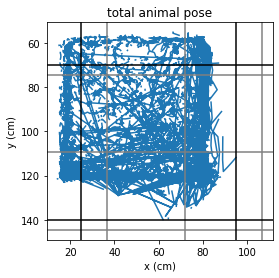

In [14]:
plt.plot(ap.pose[:,1],ap.pose[:,2])
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
#plt.scatter([xmean],[ymean], color="black", s=20)
plt.axvline(x=xmean, color="gray")
plt.axhline(y=ymean, color="gray")
plt.axvline(x=xmean+diameter/2, color="gray")
plt.axhline(y=ymean+diameter/2, color="gray")
plt.axvline(x=xmean-diameter/2, color="gray")
plt.axhline(y=ymean-diameter/2, color="gray")

plt.axvline(x=xyrange_min[0], color="black")
plt.axvline(x=xyrange_max[0], color="black")
plt.axhline(y=xyrange_min[1], color="black")
plt.axhline(y=xyrange_max[1], color="black")

plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("total animal pose")
plt.show()

Plot the occupancy map to see where the animal spent more or less time.

(The image seems mirrored since the x/y-axis for imshow is different compared to the plot function.)

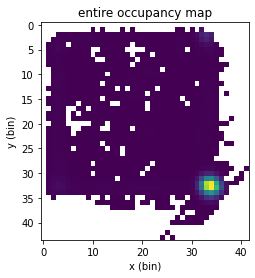

In [15]:
ap.occupancy_map_2d()
plt.imshow(ap.occupancy_map.T)
plt.xlabel("x (bin)")
plt.ylabel("y (bin)")
plt.title("entire occupancy map")
plt.show()

## Light/Dark Intervals

In [16]:
# get times from external time source
times = ses.log_times
print(times.shape)
print(times)

(82,)
[  36.31326508 1240.10552173 1303.71666826 1367.40351968 1431.00416795
 1494.73574079 1558.27354956 1621.98587993 1685.65009603 1749.21859448
 1812.83593311 1876.50343145 1940.11149302 2003.77609768 2067.38511381
 2131.06755065 2194.66152901 2258.32935487 2321.94105178 2385.65053766
 2449.24823631 2512.91556188 2576.5439405  2640.20954508 2703.81783154
 2767.48147959 2831.08173602 2895.26913938 2959.39964499 3023.06877697
 3086.67488531 3150.37648663 3214.00836609 3277.74691903 3341.34644775
 3405.03156092 3468.54733124 3532.22803691 3595.84932099 3659.54688304
 3723.15762565 3787.32384572 3851.47545403 3915.13554714 3978.75426185
 4042.41843638 4106.03036278 4169.73692787 4233.33323398 4296.99261701
 4361.11031045 4424.7921736  4488.40037057 4552.07374149 4615.68226693
 4679.35336218 4742.89744476 4806.62500138 4870.23432774 4933.90512387
 4997.50417034 5061.18137622 5124.79679056 5188.46340207 5252.09539088
 5315.7463883  5379.35997617 5443.004229   5506.63949909 5570.31401849


In [17]:
## artificially create light switches (not recommended, rather use clock sync)
## light_switches = times of light switched (on/off), starts with off, at 0s switched on
light_switches = [0.]
for i in range(2*20):
    p = 1200.+120.*i
    light_switches.append(p)
light_switches.append(p+1200)

# for i,l in enumerate(light_switches):
#    print("#",i," : ",l," (",(i+1)%2,")")

# light_dark_intervals = ap.times2intervals(light_switches)
# print(light_dark_intervals)

In [18]:
# create intervals from logged times
light_dark_intervals = ap.times2intervals(times)
print("Intervals:", light_dark_intervals.shape)
print("first: ",light_dark_intervals[0])
print("last: ",light_dark_intervals[-1])

Intervals: (81, 2)
first:  [  36.31326508 1240.10552173]
last:  [6270.38303824 7473.89421131]


In [19]:
for i,intv in enumerate(light_dark_intervals):
    print("#",i,":",intv,"-",np.diff(intv)[0],"sec","-","dark" if i%2 else "light","")

# 0 : [  36.31326508 1240.10552173] - 1203.7922566485527 sec - light 
# 1 : [1240.10552173 1303.71666826] - 63.61114653572963 sec - dark 
# 2 : [1303.71666826 1367.40351968] - 63.68685141046876 sec - light 
# 3 : [1367.40351968 1431.00416795] - 63.6006482735736 sec - dark 
# 4 : [1431.00416795 1494.73574079] - 63.73157284519925 sec - light 
# 5 : [1494.73574079 1558.27354956] - 63.537808765909176 sec - dark 
# 6 : [1558.27354956 1621.98587993] - 63.71233037348634 sec - light 
# 7 : [1621.98587993 1685.65009603] - 63.664216098329916 sec - dark 
# 8 : [1685.65009603 1749.21859448] - 63.56849844806766 sec - light 
# 9 : [1749.21859448 1812.83593311] - 63.617338626998844 sec - dark 
# 10 : [1812.83593311 1876.50343145] - 63.6674983414282 sec - light 
# 11 : [1876.50343145 1940.11149302] - 63.60806157123852 sec - dark 
# 12 : [1940.11149302 2003.77609768] - 63.66460466024773 sec - light 
# 13 : [2003.77609768 2067.38511381] - 63.609016133459136 sec - dark 
# 14 : [2067.38511381 2131.0675506

In [20]:
# select the initial baseline
baseline_interval = light_dark_intervals[0]
print("baseline_interval",baseline_interval)

baseline_interval [  36.31326508 1240.10552173]


In [21]:
# select the final baseline
baseline_interval_2 = light_dark_intervals[-1]
print("baseline_interval_2",baseline_interval_2)

baseline_interval_2 [6270.38303824 7473.89421131]


In [22]:
# select the light/dark intervals

light_dark_intervals_without_baseline = light_dark_intervals[1:-1] # remove first and last interval (baselines)
#light_dark_intervals_without_baseline = light_dark_intervals[1:] # remove first baseline

dark_intervals = light_dark_intervals_without_baseline[::2] # every second interval is dark, starting from the first one
print("dark intervals (",len(dark_intervals),")")
print(dark_intervals)

print("")

light_intervals = light_dark_intervals_without_baseline[1::2] # every second interval is dark, starting from the second one
print("light intervals (",len(light_intervals),")")
print(light_intervals)

dark intervals ( 40 )
[[1240.10552173 1303.71666826]
 [1367.40351968 1431.00416795]
 [1494.73574079 1558.27354956]
 [1621.98587993 1685.65009603]
 [1749.21859448 1812.83593311]
 [1876.50343145 1940.11149302]
 [2003.77609768 2067.38511381]
 [2131.06755065 2194.66152901]
 [2258.32935487 2321.94105178]
 [2385.65053766 2449.24823631]
 [2512.91556188 2576.5439405 ]
 [2640.20954508 2703.81783154]
 [2767.48147959 2831.08173602]
 [2895.26913938 2959.39964499]
 [3023.06877697 3086.67488531]
 [3150.37648663 3214.00836609]
 [3277.74691903 3341.34644775]
 [3405.03156092 3468.54733124]
 [3532.22803691 3595.84932099]
 [3659.54688304 3723.15762565]
 [3787.32384572 3851.47545403]
 [3915.13554714 3978.75426185]
 [4042.41843638 4106.03036278]
 [4169.73692787 4233.33323398]
 [4296.99261701 4361.11031045]
 [4424.7921736  4488.40037057]
 [4552.07374149 4615.68226693]
 [4679.35336218 4742.89744476]
 [4806.62500138 4870.23432774]
 [4933.90512387 4997.50417034]
 [5061.18137622 5124.79679056]
 [5188.46340207 5

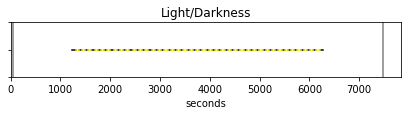

In [23]:
# visualize the light/dark intervals

plt.figure(figsize=(7,1))

plt.axvline(x=np.min(light_dark_intervals), color='grey')
plt.axvline(x=np.max(light_dark_intervals), color='grey')

plt.xlim((0,np.max(light_dark_intervals)*1.05))
plt.ylim((-0.5,0.5))
plt.gca().set(yticklabels=[])  

for dark_interval in dark_intervals:
    plt.plot(dark_interval, [0,0], color='black')
for light_interval in light_intervals:
    plt.plot(light_interval, [0,0], color='yellow')

plt.xlabel("seconds")

plt.title("Light/Darkness")

plt.show()


### **Initial Baseline**

Use the initial baseline (20min) to detect HD cells

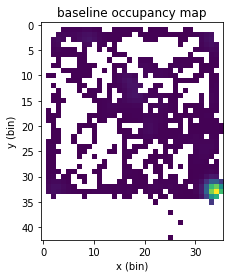

In [24]:
ap.set_intervals(baseline_interval)
ap.occupancy_map_2d()
plt.imshow(ap.occupancy_map.T)
plt.xlabel("x (bin)")
plt.ylabel("y (bin)")
plt.title("baseline occupancy map")
plt.show()

In [25]:
ap.invalid_ratio()

0.6066290081408872

In [26]:
occupancy = ap.occupancy(arena='circle') ## circle/square
print("occupancy: {:.1f} %".format(occupancy*100))

occupancy: 67.5 %


#### for each cell

interval used = [  36.31326508 1240.10552173]
i 0 / n 0
i 1 / n 1
i 2 / n 2
i 3 / n 4
i 4 / n 5
i 5 / n 9
i 6 / n 10
i 7 / n 12
i 8 / n 13
i 9 / n 14
i 10 / n 16
i 11 / n 17
i 12 / n 18
i 13 / n 20
i 14 / n 25
i 15 / n 26
i 16 / n 27
i 17 / n 28
i 18 / n 29
i 19 / n 30
i 20 / n 31
i 21 / n 32
i 22 / n 33
i 23 / n 35
HD neuron 23
i 24 / n 37
i 25 / n 39
i 26 / n 40
i 27 / n 41
i 28 / n 42
i 29 / n 44
i 30 / n 45
i 31 / n 46
i 32 / n 47
HD neuron 32
i 33 / n 50
i 34 / n 52
i 35 / n 54
i 36 / n 55
i 37 / n 56
i 38 / n 57
i 39 / n 62
i 40 / n 63
i 41 / n 64
i 42 / n 66
i 43 / n 67
i 44 / n 68
i 45 / n 71
i 46 / n 74
i 47 / n 79
i 48 / n 85
i 49 / n 88
i 50 / n 90
i 51 / n 92


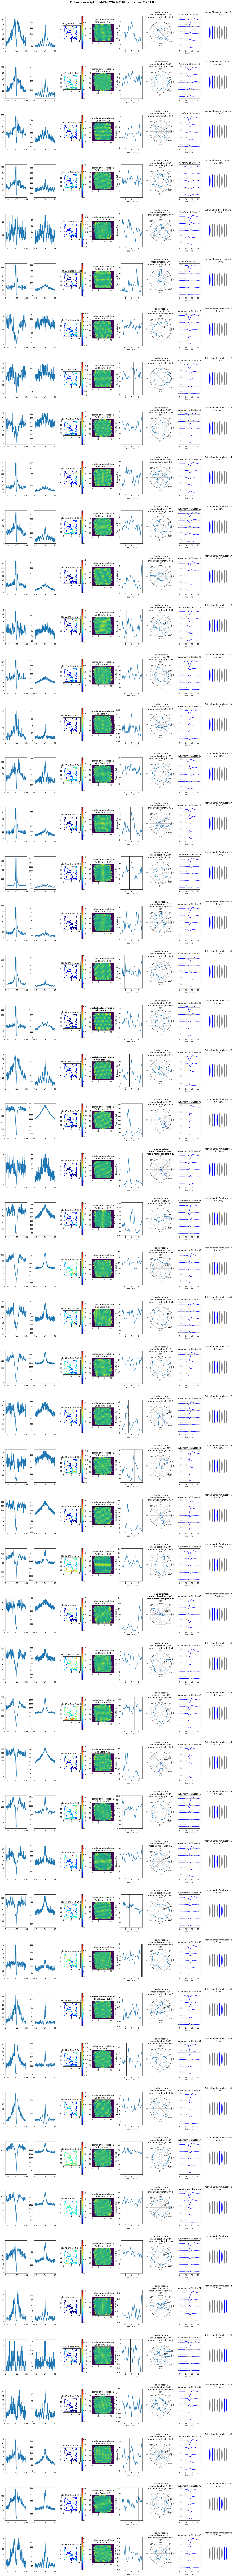

In [39]:
# make the analysis for the baseline only
iv=np.array(baseline_interval)
print("interval used =",iv)

hd_firing_list=[] # neurons tuning curve
hd_ifr_list=[] # ifr list
spike_trains = [] # spike trains
hd_neurons = [] ## list of ids of HD neurons

cg.set_spatial_properties(ap)

# from matplotlib.patches import Rectangle

cols = 8

fig, axs = plt.subplots(len(cg.neuron_list), cols, figsize=(25, 5*len(cg.neuron_list)))
   
for i, n in enumerate(cg.neuron_list):

    # reset and set intervals
    n.spike_train.unset_intervals()
    ap.unset_intervals()
    n.spike_train.set_intervals(iv)
    ap.set_intervals(iv)
    
    print("i",i,"/","n",n.name)
    # print("n",n.spike_train.intervals.total_interval_duration_seconds())
    # print("ap",ap.intervals.total_interval_duration_seconds())
    
    
    # temporal auto-correlation
      
    n.spike_train.spike_time_autocorrelation(bin_size_sec=0.0005,min_sec=-0.05, max_sec=0.05)
    timestamp = n.spike_train.mid_point_from_edges(n.spike_train.st_autocorrelation_histogram[1])
    axs[i,0].plot(timestamp, n.spike_train.st_autocorrelation_histogram[0])
    
    n.spike_train.spike_time_autocorrelation(bin_size_sec=0.0025,min_sec=-0.5, max_sec=0.5)
    timestamp = n.spike_train.mid_point_from_edges(n.spike_train.st_autocorrelation_histogram[1])
    axs[i,1].plot(timestamp, n.spike_train.st_autocorrelation_histogram[0])
    
    
    # spatial firing map 
    
    n.set_spatial_properties(ap)
    n.spatial_properties.firing_rate_map_2d(cm_per_bin =2, smoothing_sigma_cm = 2, smoothing=True)
    im = axs[i,2].imshow(n.spatial_properties.firing_rate_map,cmap='jet')
    axs[i,2].set_title("clu:{}, mRate:{:.3} Hz".format(n.name,n.spike_train.mean_firing_rate()))
    fig.colorbar(im,ax=axs[i,2])
    
    
    # Spatial autocorrelation Map & Grid Score
    gs = n.spatial_properties.grid_score()
    
    fw = "bold" if gs>.4 else "normal"
    
    axs[i,3].imshow(n.spatial_properties.spatial_autocorrelation_map)
    axs[i,3].set_title("spatial autocorrelation"+"\n"+"Grid Score: "+str(round(gs,2)), fontweight=fw)
    
    # Head direction
    
    n.spatial_properties.firing_rate_head_direction_histogram(smoothing=False)
    
    angles = n.spatial_properties.mid_point_from_edges(n.spatial_properties.firing_rate_head_direction_histo_edges)
    hd_firing = n.spatial_properties.firing_rate_head_direction_histo
    hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate = n.spatial_properties.head_direction_score()
    
    axs[i,4].plot(angles, hd_firing)
    axs[i,4].set_xlabel("Head direction")
    axs[i,4].set_ylabel("Firing rate (Hz)")
    axs[i,4].set_ylim(0,np.max(n.spatial_properties.firing_rate_head_direction_histo)*1.2)
    axs[i,4].axvline(x=hd_mean_direction_rad, color="black")
    #axs[i,4].text(s=str(round(hd_mean_direction_rad*180./np.pi))+" ° (vector length = "+str(hd_mean_vector_length)+")",x=hd_mean+.1,y=1)
    
    fw = "bold" if (hd_mean_vector_length>.4 and hd_peak_rate>3) else "normal"
    axs[i,5].axis('off')
    ax2 = fig.add_subplot(len(cg.neuron_list), cols, cols*i+6, polar=True)
    #ax2.plot(angles, hd_firing)
    ax2.plot(np.append(angles,angles[0]), np.append(hd_firing,hd_firing[0]))
    ax2.plot([hd_mean_direction_rad]*2, [0,max(hd_firing)] , color="blue", alpha=hd_mean_vector_length, lw=2.5  )
    ax2.set_title("Head direction" + "\n" + "mean direction: " + str(round( (hd_mean_direction_deg + 360) % 360  )) +"°" + "\n" + "mean vector length: " + str(np.round(hd_mean_vector_length,2))  , fontweight=fw) 
    ax2.grid(True)
    
    
    # Waveforms
    
    cluster = int(n.name) # current cluster name
    channels = ses.get_channels_from_cluster(cluster) # get channels with highest amplitude
    
    if (len(channels)):
    
        for j,channel in enumerate(channels):
            channel_mapped, waveform = ses.get_waveform_from_cluster(cluster, channel)
            axs[i,6].axhline( y = -j*.5 , color="grey" , lw=.5 )
            #label = "channel: "+str(channel)+" ("+str(channel_mapped)+")"
            label = "channel "+str(channel_mapped)
            axs[i,6].plot( waveform -j*.5 , label=label , color="blue")
            axs[i,6].text( s= label , x=0, y=-j*.5 +.1 )
        axs[i,6].set_xlabel("time sample")
        axs[i,6].set(yticklabels=[])  
        axs[i,6].set_title("Waveform of Cluster "+str(cluster))
        
    # channels / shanks / brain region
    shanks_arr, active_shanks, electrodes = ses.get_active_shanks(channels)
    brain_region = '/'.join(electrodes)
   
    for j, (shank, active) in enumerate(zip(ses.shanks_all, shanks_arr)):
        color = 'blue' if active else 'gray'
        circle = plt.Circle((j,0), 0.2, color=color)
        axs[i,7].add_patch(circle)

    
    axs[i,7].axis('off')
    axs[i,7].set_title("Active Shanks for cluster "+str(cluster)+"\n"+', '.join([str(int(active_shank)) for active_shank in active_shanks]) + " ("+brain_region+")")
    
    axs[i,7].set_xlim([-1, len(ses.shanks_all)])
    axs[i,7].set_ylim([-0.5, 0.5])
    
    ###########################
    # classify, find category: Grid cell, HD cell
    
    is_hd_cell = (hd_mean_vector_length>.4 and hd_peak_rate>3 and brain_region=="adn")
    if (hd_mean_vector_length > 0.4):
        n.spike_train.instantaneous_firing_rate(bin_size_sec=2.e-2)
        # print("n.name",n.name)
        # print("n.spike_train.ifr",n.spike_train.ifr)
        # print("n.spike_train.st",n.spike_train.st)
        
        hd_firing_list.append(hd_firing)
        hd_ifr_list.append(n.spike_train.ifr)
        spike_trains.append(n.spike_train.st)
        
        hd_neurons.append(i)
        print("HD neuron",i)
        
        #rect = Rectangle((0.08, 1-(i+.5)/len(cg.neuron_list)), 0.85, 1/len(cg.neuron_list), facecolor='yellow', edgecolor='none', transform=fig.transFigure, zorder=-1)
        #fig.patches.append(rect)

    
plt.suptitle("Cell overview ({}) - Baseline ({:.1f} s)".format(name, n.spike_train.intervals.total_interval_duration_seconds()), fontsize=16, fontweight='bold')
#plt.tight_layout()
#fig.subplots_adjust(wspace=0.33, hspace=.5)
fig.subplots_adjust(wspace=0.33, hspace=.5, top=0.975)
plt.savefig('/home/pascal/Documents/science_docs/analysis_results/'+name+'_baseline.pdf')
plt.show()


### After darkness (block-binning)

*define the blocks*

#### manually

In [25]:
# convert intervals to blocks of 10 seconds duration

#blocks = 12 # 120 seconds / 12 blocks = 10 second per block
blocks=6

dark_intervals_divided = []

for dark_interval in dark_intervals:
    print("dark_interval:", dark_interval)
    dark_interval_divided = np.linspace(dark_interval[0],dark_interval[1],blocks+1)
    print("dark_interval_divided","(",len(dark_interval_divided),"steps )",":", dark_interval_divided)
    dark_intervals_divided.append(ap.times2intervals(dark_interval_divided))
    print("")

dark_interval: [1220.66300692 1284.27266566]
dark_interval_divided ( 7 steps ) : [1220.66300692 1231.26461671 1241.8662265  1252.46783629 1263.06944608
 1273.67105587 1284.27266566]

dark_interval: [1347.96533521 1411.57460826]
dark_interval_divided ( 7 steps ) : [1347.96533521 1358.56688072 1369.16842623 1379.76997173 1390.37151724
 1400.97306275 1411.57460826]

dark_interval: [1475.23634656 1538.83933723]
dark_interval_divided ( 7 steps ) : [1475.23634656 1485.83684501 1496.43734345 1507.0378419  1517.63834034
 1528.23883879 1538.83933723]

dark_interval: [1602.49326106 1666.02369339]
dark_interval_divided ( 7 steps ) : [1602.49326106 1613.08166645 1623.67007184 1634.25847722 1644.84688261
 1655.435288   1666.02369339]

dark_interval: [1729.69539859 1793.30324186]
dark_interval_divided ( 7 steps ) : [1729.69539859 1740.2967058  1750.89801301 1761.49932023 1772.10062744
 1782.70193465 1793.30324186]

dark_interval: [1857.00016298 1920.62213975]
dark_interval_divided ( 7 steps ) : [185

In [26]:
dark_intervals_divided = np.transpose(dark_intervals_divided,(1,0,2))

print("dark_intervals_divided",dark_intervals_divided.shape)
print(dark_intervals_divided)

dark_intervals_divided (6, 40, 2)
[[[1220.66300692 1231.26461671]
  [1347.96533521 1358.56688072]
  [1475.23634656 1485.83684501]
  [1602.49326106 1613.08166645]
  [1729.69539859 1740.2967058 ]
  [1857.00016298 1867.60382578]
  [1984.27717819 1994.87852053]
  [2111.53282116 2122.14115254]
  [2238.82706522 2249.42664724]
  [2366.11089324 2376.71298266]
  [2493.364608   2503.96887591]
  [2620.63292519 2631.23772137]
  [2747.96341073 2758.5510113 ]
  [2875.20203884 2885.79659663]
  [3002.43389735 3013.02857269]
  [3129.63428406 3140.23901973]
  [3256.95167708 3267.54929533]
  [3384.72219199 3395.32156143]
  [3512.09772546 3522.70444733]
  [3639.42053369 3650.02052298]
  [3766.72196981 3777.31756482]
  [3893.96698318 3904.57704427]
  [4021.27546335 4031.96096429]
  [4149.08318814 4159.67988395]
  [4276.39833132 4286.99109977]
  [4403.6264235  4414.23091592]
  [4530.97141596 4541.57737678]
  [4658.27883153 4668.88277523]
  [4785.57446815 4796.17802418]
  [4912.86719605 4923.4681747 ]
  [504

In [27]:
first_block = dark_intervals_divided[0] # first 10 seconds with darkness after light
print(first_block)

[[1220.66300692 1231.26461671]
 [1347.96533521 1358.56688072]
 [1475.23634656 1485.83684501]
 [1602.49326106 1613.08166645]
 [1729.69539859 1740.2967058 ]
 [1857.00016298 1867.60382578]
 [1984.27717819 1994.87852053]
 [2111.53282116 2122.14115254]
 [2238.82706522 2249.42664724]
 [2366.11089324 2376.71298266]
 [2493.364608   2503.96887591]
 [2620.63292519 2631.23772137]
 [2747.96341073 2758.5510113 ]
 [2875.20203884 2885.79659663]
 [3002.43389735 3013.02857269]
 [3129.63428406 3140.23901973]
 [3256.95167708 3267.54929533]
 [3384.72219199 3395.32156143]
 [3512.09772546 3522.70444733]
 [3639.42053369 3650.02052298]
 [3766.72196981 3777.31756482]
 [3893.96698318 3904.57704427]
 [4021.27546335 4031.96096429]
 [4149.08318814 4159.67988395]
 [4276.39833132 4286.99109977]
 [4403.6264235  4414.23091592]
 [4530.97141596 4541.57737678]
 [4658.27883153 4668.88277523]
 [4785.57446815 4796.17802418]
 [4912.86719605 4923.4681747 ]
 [5040.0972547  5050.70237581]
 [5167.37244223 5177.97334915]
 [5294.6

#### more automatically

In [29]:
def intervals_to_blocks(intervals, blocks):
    intervals_divided = []
    
    for interval in intervals:
        interval_divided = np.linspace(interval[0],interval[1],blocks+1)
        intervals_divided.append(ap.times2intervals(interval_divided))
        
    intervals_divided_transposed = np.transpose(intervals_divided,(1,0,2))

    return intervals_divided_transposed

In [30]:
blocks = 6
light_intervals_divided = intervals_to_blocks(light_intervals, blocks)
dark_intervals_divided = intervals_to_blocks(dark_intervals, blocks)
print("light_intervals_divided", light_intervals_divided.shape)
print("dark_intervals_divided", dark_intervals_divided.shape)

light_intervals_divided (6, 39, 2)
dark_intervals_divided (6, 40, 2)


#### Pick some good HD neurons manually

#### **Analyse all HD neurons**

In [41]:
hd_neurons

[23, 32]

In [31]:
# hd_neurons = [18,36] # manually defined

In [32]:
intervals = [baseline_interval, light_intervals, dark_intervals, None]
intervals.extend(light_intervals_divided)
intervals.extend(dark_intervals_divided)
#~ print(len(intervals),intervals)

labels = ["Baseline","all light","all dark",None] # "light"/"darkness"
col_ids = [0, 1, 1, 2]

light_intervals_divided_labels = [ "light block {}".format(b+1) for b,i in enumerate(light_intervals_divided) ]
labels.extend(light_intervals_divided_labels)
col_ids.extend(range(3,3+len(light_intervals_divided_labels)))

dark_intervals_divided_labels = [ "dark block {}".format(b+1) for b,i in enumerate(dark_intervals_divided) ]
labels.extend(dark_intervals_divided_labels)
col_ids.extend(range(3,3+len(dark_intervals_divided_labels)))


#~ print(labels)
width_ratios = [1, 1, 0.5] + blocks*[1]

legends = [False, True, True, None] + 2*blocks*[True]

#~ for col_id,interval,label,legend in zip(col_ids, intervals, labels, legends):
#~     print(col_id, interval.shape if not interval is None else 'None','"'+str(label)+'"',legend)

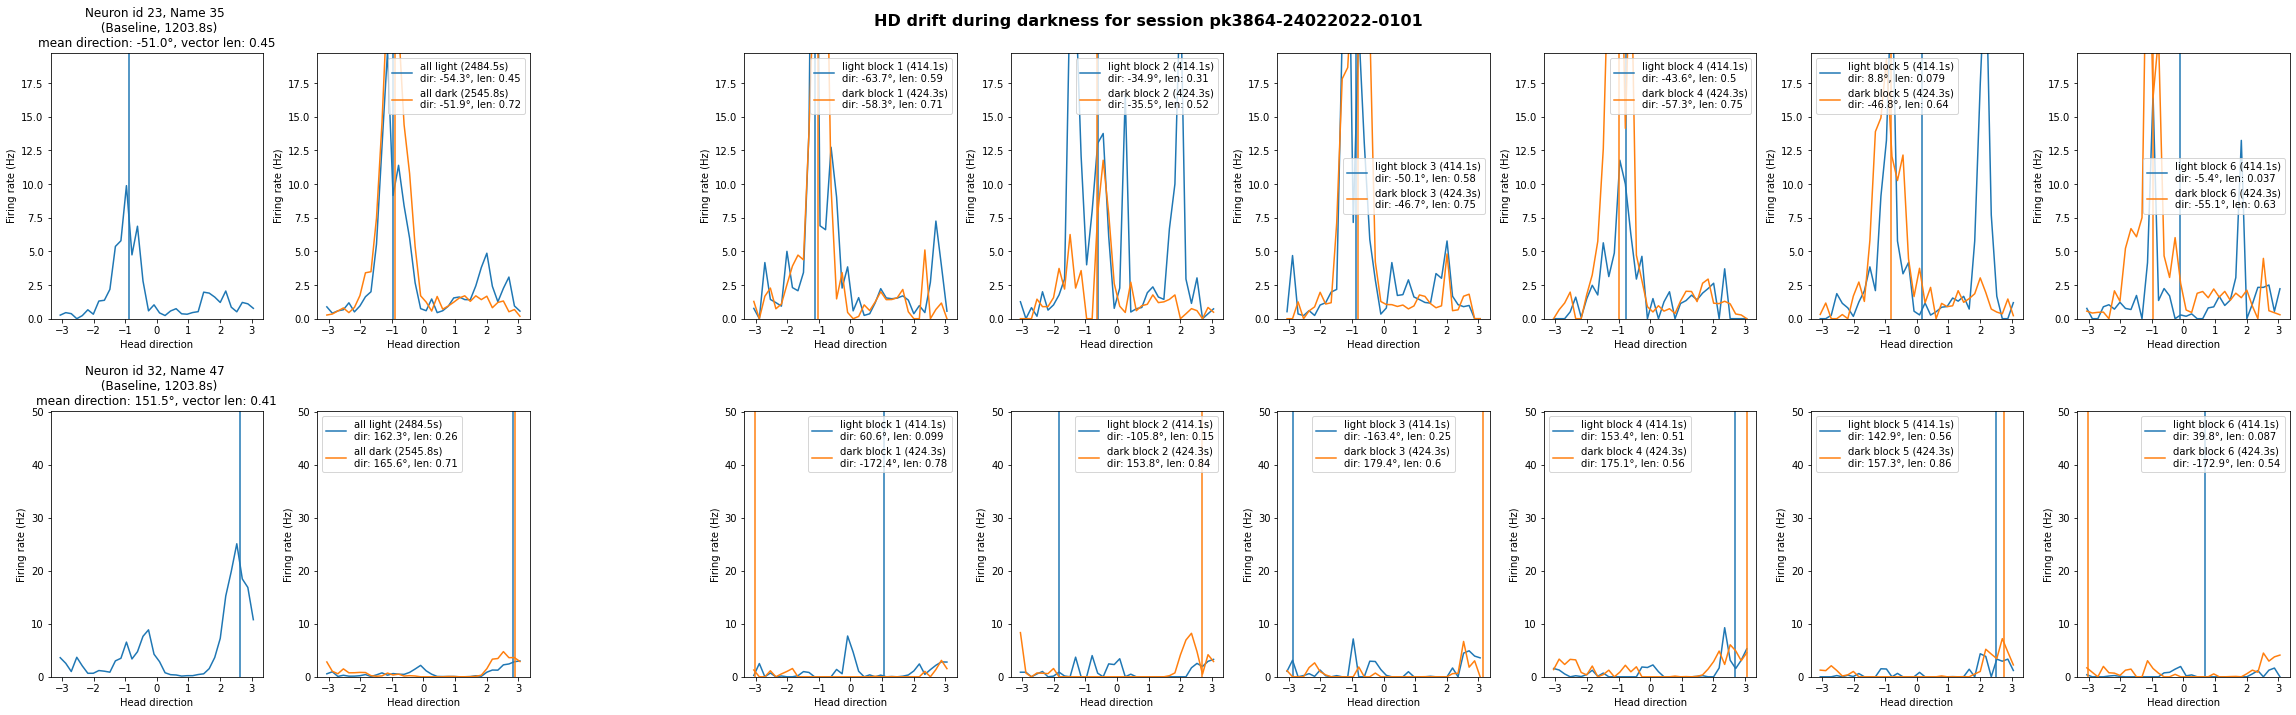

In [40]:
fig, axs = plt.subplots(len(hd_neurons), 2+1+blocks, figsize=(4*(2+blocks), 5*len(hd_neurons)), gridspec_kw={'width_ratios': width_ratios})
# rows,cols, figsize=(width,height)

for i,index in enumerate(hd_neurons):
    
    ## select neuron from list
    
    n = cg.neuron_list[index]
    
    
    ## HD tuning curve: first for references: baseline & darkness, then for each block in darkness (light respectively)
    
    #for j,(interval,label) in enumerate(zip(intervals,labels)):
    for col_id,interval,label,legend in zip(col_ids, intervals, labels, legends):
        
        j = col_id
        
        if interval is None:
            axs[i,j].set_visible(False)
            continue
        
        #~ print(j,(interval,label))
        #~ continue

        # reset and set intervals
        n.spike_train.unset_intervals()
        ap.unset_intervals()
        n.spike_train.set_intervals(interval)
        ap.set_intervals(interval)

        #~ print("n",n.spike_train.intervals.total_interval_duration_seconds())
        #~ print("ap",ap.intervals.total_interval_duration_seconds())
        total_duration = n.spike_train.intervals.total_interval_duration_seconds()

        n.set_spatial_properties(ap)

        n.spatial_properties.firing_rate_head_direction_histogram(smoothing=False)

        angles = n.spatial_properties.mid_point_from_edges(n.spatial_properties.firing_rate_head_direction_histo_edges)
        hd_firing = n.spatial_properties.firing_rate_head_direction_histo
        hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate = n.spatial_properties.head_direction_score()

        axs[i,j].plot(angles, hd_firing, label=label+" ({:.1f}s)".format(total_duration) + "\n" + "dir: {:.1f}°, len: {:.2}".format(hd_mean_direction_deg,hd_mean_vector_length) )
        axs[i,j].set_xlabel("Head direction")
        axs[i,j].set_ylabel("Firing rate (Hz)")
        if j==0:
            ymax = np.max(n.spatial_properties.firing_rate_head_direction_histo)*2. # first col defines y scaling
        axs[i,j].set_ylim(0,ymax)
        axs[i,j].axvline(x=hd_mean_direction_rad, color=axs[i,j].lines[-1].get_color())
        axs[i,j].set_title("Neuron id {}, Name {} \n ({}, {:.1f}s)".format(index,n.name,label,total_duration) + "\n" + "mean direction: {:.1f}°, vector len: {:.2}".format(hd_mean_direction_deg,hd_mean_vector_length))
        
        if (legend):
            axs[i,j].legend()
            axs[i,j].set_title('')
    
plt.suptitle("HD drift during darkness for session "+name, fontsize=16, fontweight='bold')
plt.tight_layout()
fig.subplots_adjust(top=0.925)
plt.savefig('/home/pascal/Documents/science_docs/analysis_results/'+name+'_HD-drift.pdf')
plt.show()

In [36]:
n

In [43]:
def hd_tuning(n, interval):
    n.spike_train.unset_intervals()
    ap.unset_intervals()
    n.spike_train.set_intervals(interval)
    ap.set_intervals(interval)

    total_duration = n.spike_train.intervals.total_interval_duration_seconds()

    n.set_spatial_properties(ap)

    n.spatial_properties.firing_rate_head_direction_histogram(smoothing=False)

    angles = n.spatial_properties.mid_point_from_edges(n.spatial_properties.firing_rate_head_direction_histo_edges)
    hd_firing = n.spatial_properties.firing_rate_head_direction_histo
    hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate = n.spatial_properties.head_direction_score()
    
    return (total_duration, (angles, hd_firing), (hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate))

In [39]:
hd_tuning(n, np.array([1,1000]))

(206.1576441929385,
 (array([-3.05432619, -2.87979327, -2.70526034, -2.53072742, -2.35619449,
         -2.18166156, -2.00712864, -1.83259571, -1.65806279, -1.48352986,
         -1.30899694, -1.13446401, -0.95993109, -0.78539816, -0.61086524,
         -0.43633231, -0.26179939, -0.08726646,  0.08726646,  0.26179939,
          0.43633231,  0.61086524,  0.78539816,  0.95993109,  1.13446401,
          1.30899694,  1.48352986,  1.65806279,  1.83259571,  2.00712864,
          2.18166156,  2.35619449,  2.53072742,  2.70526034,  2.87979327,
          3.05432619]),
  array([0.00000000e+00, 1.24481328e+00, 1.95694716e-01, 7.32064422e-02,
         1.06609808e-01, 0.00000000e+00, 1.02249489e-01, 1.91570881e-01,
         1.00000000e+00, 2.09205021e-01, 1.82481752e-01, 2.40384615e-01,
         0.00000000e+00, 0.00000000e+00, 1.71232877e+00, 1.62790698e+00,
         5.37848606e+00, 1.46408840e+01, 3.97619048e+01, 6.47398844e+01,
         6.50793651e+01, 1.05312500e+02, 1.40109890e+02, 1.58715596e+02,


In [57]:
total_duration, (angles, hd_firing_1), (hd_score) = hd_tuning(n, baseline_interval)
print(total_duration)
total_duration, (angles, hd_firing_2), (hd_score) = hd_tuning(n, baseline_interval_2)
print(total_duration)

1203.9990691318883
1203.577801350013


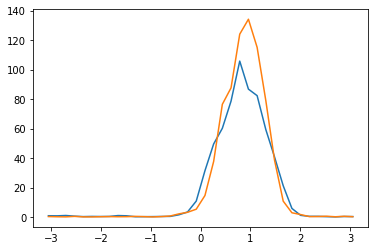

In [58]:
plt.plot(angles, hd_firing_1)
plt.plot(angles, hd_firing_2)

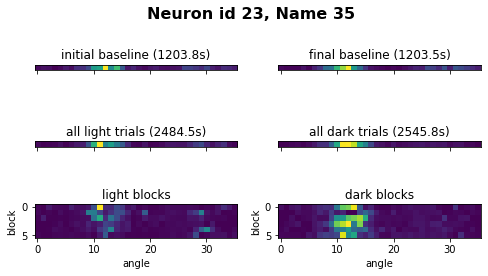

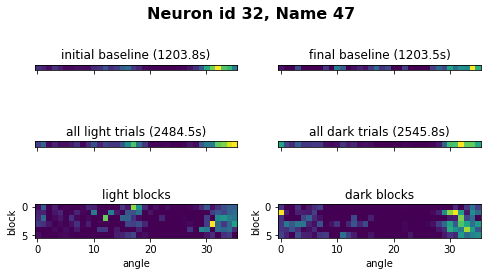

In [44]:
for i,index in enumerate(hd_neurons):
    
    ## select neuron from list
    
    n = cg.neuron_list[index]


    fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=False, figsize=(8,4))
    #fig.subplots_adjust(hspace=0)

    # initial baseline
    total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, baseline_interval)
    axes[0,0].imshow([hd_firing])
    axes[0,0].get_yaxis().set_visible(False)
    #axes[0,0].set(yticklabels=[])
    #axes[0,0].set_ylabel(".")
    axes[0,0].set_title("initial baseline ({:.1f}s)".format(total_duration))

    # final baseline
    total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, baseline_interval_2)
    axes[0,1].imshow([hd_firing])
    axes[0,1].get_yaxis().set_visible(False)
    axes[0,1].set_title("final baseline ({:.1f}s)".format(total_duration))

    # all light trials combined
    total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, light_intervals)
    axes[1,0].imshow([hd_firing])
    axes[1,0].get_yaxis().set_visible(False)
    axes[1,0].set_title("all light trials ({:.1f}s)".format(total_duration))

    # all darkness trials combined
    total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, dark_intervals)
    axes[1,1].imshow([hd_firing])
    axes[1,1].get_yaxis().set_visible(False)
    axes[1,1].set_title("all dark trials ({:.1f}s)".format(total_duration))

    # light blocks
    hd_firing_all_light = []
    for light_interval in light_intervals_divided:
        total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, light_interval)
        hd_firing_all_light.append(hd_firing)
    #im = axes[2,0].pcolor(angles, range(len(hd_firing_all_light)), hd_firing_all_light, shading='auto', cmap='Greys')#, vmin=0, vmax=np.nanmax(hd_firing_all_light))
    axes[2,0].imshow(hd_firing_all_light)
    # axes[2,0].invert_yaxis()
    axes[2,0].set_xlabel("angle")
    axes[2,0].set_ylabel("block")
    axes[2,0].set_title("light blocks")

    # dark blocks
    hd_firing_all_dark = []
    for dark_interval in dark_intervals_divided:
        total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, dark_interval)
        hd_firing_all_dark.append(hd_firing)
    axes[2,1].imshow(hd_firing_all_dark)
    axes[2,1].set_xlabel("angle")
    axes[2,1].set_ylabel("block")
    axes[2,1].set_title("dark blocks")

    # plt.suptitle("HD drift for session "+name, fontsize=16, fontweight='bold')
    
    plt.suptitle("Neuron id {}, Name {}".format(index,n.name), fontsize=16, fontweight='bold')
    
    plt.show()

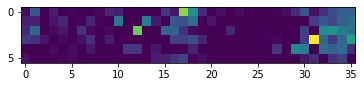

In [45]:
plt.imshow(np.array(hd_firing_all_light))

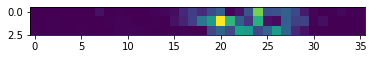

In [82]:
plt.imshow(np.array(hd_firing_all_light)[:3])

In [ ]:



im = plt.pcolor(angles, range(len(hd_firing_all)), hd_firing_all, shading='auto', cmap='Greys', vmin=0, vmax=np.max(hd_firing_all))
add_colorbar(im)
plt.xlabel("angle")
plt.ylabel("time")
plt.gca().invert_yaxis()
plt.title("HD tuning curve (firing rate), with temporal resolution")
plt.show()

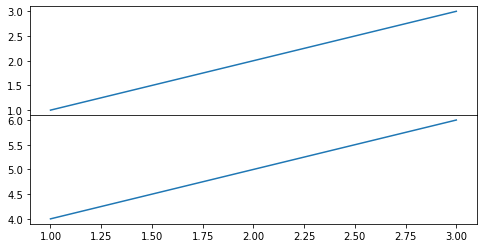

In [86]:
fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=False, figsize=(8,4))
fig.subplots_adjust(hspace=0)
axes[0].plot([1,2,3],[1,2,3])
axes[1].plot([1,2,3],[4,5,6])
plt.show()


In [ ]:
### create mask for square box 70cm

import numpy as np
import matplotlib.pyplot as plt

# dimensions of frame
h,w=840,540
# create mask
m=np.zeros((h,w))
print("mask:", m.shape)

# length of square box in pixels (70cm*5.7px/cm)
l=int(70*5.7)

# left, and upper coordinates
x0=int((w-l)/2)
y0=int(h-l-x0)

# print the coordinates
print("x0:",x0)
print("y0:",y0)
print("l:",l)

# set mask
m[y0:y0+l,x0:x0+l]=1

# plot
plt.imshow(m)
plt.show()

# convert to 8bit image (scale by 255 & dtype=uint8)
m = 255 * m
img = m.astype(np.uint8)

# save
np.save("a230-pc82_square70_mask.npy", img)


## scp a230-pc82_square70_mask.npy kevin@a230-pc82:/home/kevin/repo/positrack2/data/masks
## scp a230-pc82_square70_mask.npy kevin@a230-pc52:/home/kevin/repo/positrack2/data/masks